In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Navigate to your project location
%cd /content/drive/MyDrive/Colab Notebooks/Projects/Schrodinger NO

/content/drive/MyDrive/Colab Notebooks/Projects/Schrodinger NO


In [3]:
"""
Schrödinger FNO Training with Official PyTorch NeuralOperator
"""
!pip install neuraloperator
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

# The official library
from neuralop.models import FNO


In [4]:
class SchrodingerDataset(Dataset):
    """
    Computes statistics only on the data you're training on,
    not on the entire dataset including validation.
    """

    def __init__(self, h5_path, train=True, val_split=0.1, norm_stats=None):
        """
        Args:
            h5_path: Path to HDF5 file
            train: Whether this is training or validation set
            val_split: Fraction of data for validation
            norm_stats: Pre-computed normalization stats (for val set)
        """
        with h5py.File(h5_path, 'r') as f:
            potentials = f['potentials'][:]
            energies = f['energies'][:]
            wavefunctions = f['wavefunctions'][:]
            self.x_grid = f['x_grid'][:]

        # Split data
        n_samples = len(potentials)
        n_val = int(n_samples * val_split)

        if train:
            self.potentials = potentials[:-n_val]
            self.energies = energies[:-n_val]
            self.wavefunctions = wavefunctions[:-n_val]
        else:
            self.potentials = potentials[-n_val:]
            self.energies = energies[-n_val:]
            self.wavefunctions = wavefunctions[-n_val:]

        # Compute or use normalization stats
        if norm_stats is None:
            # Training set: compute stats on OUR data only
            self.V_mean = np.mean(self.potentials)
            self.V_std = np.std(self.potentials) + 1e-8
            self.E_mean = np.mean(self.energies)
            self.E_std = np.std(self.energies) + 1e-8

            if train:
                print(f"Normalization stats (computed on {len(self)} training samples):")
                print(f"  Potential: μ={self.V_mean:.2f}, σ={self.V_std:.2f}")
                print(f"  Energy: μ={self.E_mean:.2f}, σ={self.E_std:.2f}")
        else:
            # Validation set: use training set's stats
            self.V_mean = norm_stats['V_mean']
            self.V_std = norm_stats['V_std']
            self.E_mean = norm_stats['E_mean']
            self.E_std = norm_stats['E_std']

    def get_norm_stats(self):
        """Return normalization stats for use in validation set."""
        return {
            'V_mean': self.V_mean,
            'V_std': self.V_std,
            'E_mean': self.E_mean,
            'E_std': self.E_std
        }

    def __len__(self):
        return len(self.potentials)

    def __getitem__(self, idx):
        V = self.potentials[idx]
        E = self.energies[idx]
        psi = self.wavefunctions[idx]

        # Normalize
        V = (V - self.V_mean) / self.V_std
        E = (E - self.E_mean) / self.E_std

        return (
            torch.FloatTensor(V),
            torch.FloatTensor(E),
            torch.FloatTensor(psi)
        )

In [5]:
# ============================================================================
# Model Wrapper
# ============================================================================

class SchrodingerNeuralOperator(nn.Module):
    """
    Architecture:
    - Shared FNO encoder learns features from V(x)
    - Branch 1: Decode to wavefunctions ψ(x)
    """

    def __init__(
        self,
        n_modes=(16,),
        hidden_channels=64,
        n_layers=4,
        n_eigenstates=4,
        n_points=256,
    ):
        super().__init__()

        self.n_eigenstates = n_eigenstates
        self.n_points = n_points
        self.hidden_channels = hidden_channels

        # Main FNO for learning V(x) representation
        self.fno = FNO(
            n_modes=n_modes,
            hidden_channels=hidden_channels,
            in_channels=1,
            out_channels=hidden_channels,  # Keep in feature space
            n_layers=n_layers,
        )

        # Wavefunction decoder: features → ̓(x)
        self.wavefunction_decoder = nn.Sequential(
            nn.Conv1d(hidden_channels, hidden_channels // 2, kernel_size=1),
            nn.GELU(),
            nn.Conv1d(hidden_channels // 2, n_eigenstates, kernel_size=1)
        )

    def forward(self, V_normalized):
        """
        V_normalized: (batch, n_points)
        Returns:
            wavefunctions: (batch, n_eigenstates, n_points) (normalized)
        """
        # Encode potential with FNO
        V_in = V_normalized.unsqueeze(1)  # (batch, 1, n_points)
        features = self.fno(V_in)  # (batch, hidden_channels, n_points)

        # Decode to wavefunctions
        wavefunctions = self.wavefunction_decoder(features)  # (batch, n_eigenstates, n_points)

        return wavefunctions

In [6]:
import torch.nn.functional as F

def laplacian(psi, dx):
    """
    Computes the second spatial derivative (Laplacian) using a 3-point stencil.
    Assumes psi is (batch, n_eigenstates, n_points).
    """
    # Replicate padding to handle boundaries without assuming psi=0
    psi_padded = F.pad(psi, (1, 1), mode='replicate')
    laplacian_val = (
        psi_padded[:, :, :-2] - 2 * psi_padded[:, :, 1:-1] + psi_padded[:, :, 2:]
    ) / (dx**2)
    return laplacian_val

def energy_from_psi_multi_eigenstate(psi_normalized, V_normalized, dx, norm_stats, hbar=1.0, mass=1.0):
    """
    Calculates the expectation value of energy for each eigenstate from predicted wavefunctions.
    All inputs are expected to be normalized except dx.
    Returns denormalized energies (batch, n_eigenstates).
    """
    # Denormalize potential for physical calculation
    V_denormalized = V_normalized * norm_stats['V_std'] + norm_stats['V_mean']
    V_expanded = V_denormalized.unsqueeze(1) # (batch, 1, n_points)

    # Calculate Laplacian of normalized psi
    d2psi_normalized = laplacian(psi_normalized, dx)

    # Normalize each wavefunction before calculating expectation value
    # This is important to ensure ⟨psi|psi⟩ = 1
    norms = torch.sqrt(torch.sum(psi_normalized**2, dim=-1, keepdim=True) * dx + 1e-10)
    psi_normalized_for_expectation = psi_normalized / norms

    # Kinetic energy term: -hbar²/2m * ∇²ψ
    kinetic_term = -hbar**2 / (2 * mass) * d2psi_normalized

    # Potential energy term: Vψ
    potential_term = V_expanded * psi_normalized_for_expectation

    # Hamiltonian applied to psi: Hψ = Tψ + Vψ
    Hpsi = kinetic_term + potential_term

    # Energy expectation value: ⟨ψ|Hψ⟩ = ∫ ψ* Hψ dx. Assuming real wavefunctions, ψ* = ψ
    # Integral is sum * dx
    energies_calculated = torch.sum(psi_normalized_for_expectation * Hpsi, dim=-1) * dx

    return energies_calculated


def energy_loss(E_pred, E_true):
    """Energy Loss (both are normalized)."""
    return F.mse_loss(E_pred, E_true)


def wavefunction_overlap_loss(psi_pred, psi_true, dx):
    """
    Phase-invariant overlap loss: 1 - |⟨ψ_pred|ψ_true⟩|²
    Inputs are normalized.
    """
    # Normalize
    norm_pred = torch.sqrt(torch.sum(psi_pred**2, dim=-1, keepdim=True) * dx + 1e-10)
    norm_true = torch.sqrt(torch.sum(psi_true**2, dim=-1, keepdim=True) * dx + 1e-10)

    psi_pred_norm = psi_pred / norm_pred
    psi_true_norm = psi_true / norm_true

    # Overlap: ⟨ψ_pred|ψ_true⟩
    overlap = torch.sum(psi_pred_norm * psi_true_norm, dim=-1) * dx

    # Loss: 1 - |overlap|²
    loss = 1 - overlap**2

    return loss.mean()


def orthogonality_loss(psi, dx):
    """
    Enforce ⟨ψ_i|ψ_j⟩ = δ_ij. Eigenstates should be orthogonal.
    Inputs are normalized.
    """
    batch, n_states, n_points = psi.shape

    # Normalize each state
    norms = torch.sqrt(torch.sum(psi**2, dim=-1, keepdim=True) * dx + 1e-10)
    psi_norm = psi / norms

    # Compute Gram matrix: G_ij = ⟨ψ_i|ψ_j⟩
    gram = torch.einsum('bik,bjk->bij', psi_norm, psi_norm) * dx

    # Should be identity matrix
    identity = torch.eye(n_states, device=psi.device).unsqueeze(0)

    return F.mse_loss(gram, identity.expand(batch, -1, -1))


def physics_residual_loss(psi_normalized, E_normalized, V_normalized, dx, norm_stats, hbar=1.0, mass=1.0):
    """
    Ensure Hψ = Eψ where H = -ℏ²/2m ∇² + V.
    Inputs are normalized. Denormalize V and E for physical calculation.
    """
    # Denormalize V and E for physics equation
    V_denormalized = V_normalized * norm_stats['V_std'] + norm_stats['V_mean']
    E_denormalized = E_normalized * norm_stats['E_std'] + norm_stats['E_mean']

    # Laplacian via finite differences with replicate padding
    d2psi_normalized = laplacian(psi_normalized, dx)

    # Kinetic energy term: -ℏ²/2m ∇²ψ
    kinetic = -hbar**2 / (2 * mass) * d2psi_normalized

    # Potential energy term: Vψ
    potential = V_denormalized.unsqueeze(1) * psi_normalized

    # Hamiltonian: Hψ = Tψ + Vψ
    H_psi = kinetic + potential

    # Target: Eψ
    E_psi = E_denormalized.unsqueeze(-1) * psi_normalized

    return F.mse_loss(H_psi, E_psi)


class AdaptiveLossWeighting:
    """
    Dynamically balance loss components based on their relative magnitudes.
    """

    def __init__(self, alpha_init=1.0, beta_init=1.0, gamma_init=0.1,
                 delta_init=0.1, eta_init=0.1, momentum=0.9):
        self.weights = {
            'energy': alpha_init,
            'wavefunction': beta_init,
            'residual': gamma_init,
            'orthogonal': delta_init,
            'normalization': eta_init
        }
        self.momentum = momentum
        self.loss_ema = {}  # Exponential moving average of losses

    def update(self, losses):
        """Update weights based on loss magnitudes."""
        for key, value in losses.items():
            if key not in self.loss_ema:
                self.loss_ema[key] = value
            else:
                self.loss_ema[key] = (
                    self.momentum * self.loss_ema[key] +
                    (1 - self.momentum) * value
                )

    def get_weights(self):
        """Return current weights (can be made adaptive if needed)."""
        return self.weights


def normalization_loss(psi, dx):
    """
    Ensure wavefunctions are normalized (integral of |psi|^2 = 1).
    Inputs are normalized.
    """
    norm = torch.sum(psi**2, dim=-1) * dx
    return torch.mean((norm - 1.0)**2)



def combined_loss(
    E_pred_normalized, psi_pred_normalized, E_true_normalized, psi_true_normalized,
    V_normalized, dx, weighting, norm_stats
):
    """
    The unified loss function.
    Expects all E, psi, V to be normalized (except dx).
    """

    losses = {}
    losses['energy'] = energy_loss(E_pred_normalized, E_true_normalized)
    losses['wavefunction'] = wavefunction_overlap_loss(psi_pred_normalized, psi_true_normalized, dx)
    losses['residual'] = physics_residual_loss(
        psi_pred_normalized, E_pred_normalized, V_normalized, dx, norm_stats
    )
    losses['orthogonal'] = orthogonality_loss(psi_pred_normalized, dx)
    losses['normalization'] = normalization_loss(psi_pred_normalized, dx)

    # Update weighting
    weighting.update({k: v.item() for k, v in losses.items()})
    weights = weighting.get_weights()

    # Weighted sum
    total = (
        weights['energy'] * losses['energy'] +
        weights['wavefunction'] * losses['wavefunction'] +
        weights['residual'] * losses['residual'] +
        weights['orthogonal'] * losses['orthogonal'] +
        weights['normalization'] * losses['normalization']
    )

    return total, losses

In [7]:
# @title
# ============================================================================
# Training
# ============================================================================

def train_epoch(model, loader, optimizer, device, dx, weighting, norm_stats, clip_norm=1.0):
    """Train for one epoch with gradient clipping."""
    model.train()
    epoch_losses = {
        'total': 0, 'energy': 0, 'wavefunction': 0,
        'residual': 0, 'orthogonal': 0, 'normalization': 0
    }

    pbar = tqdm(loader, desc='Training')
    for V_normalized, E_true_normalized, psi_true_normalized in pbar:
        V_normalized = V_normalized.to(device)
        E_true_normalized = E_true_normalized.to(device)
        psi_true_normalized = psi_true_normalized.to(device)

        optimizer.zero_grad()

        # Model now only predicts psi
        psi_pred_normalized = model(V_normalized)

        # Compute E_pred from psi_pred using physics formula
        E_pred_denormalized = energy_from_psi_multi_eigenstate(
            psi_pred_normalized, V_normalized, dx, norm_stats
        )
        # Normalize E_pred for consistency with E_true_normalized in energy_loss
        E_pred_normalized = (
            E_pred_denormalized - norm_stats['E_mean']
        ) / norm_stats['E_std']

        total_loss, losses = combined_loss(
            E_pred_normalized, psi_pred_normalized, E_true_normalized,
            psi_true_normalized, V_normalized, dx, weighting, norm_stats
        )

        total_loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)

        optimizer.step()

        # Accumulate losses
        epoch_losses['total'] += total_loss.item()
        for key, value in losses.items():
            epoch_losses[key] += value.item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{total_loss.item():.4f}',
            'E': f'{losses["energy"].item():.4f}',
            '\u03c8': f'{losses["wavefunction"].item():.4f}',
            'orth': f'{losses["orthogonal"].item():.4f}'
        })

    # Average over batches
    n = len(loader)
    return {k: v/n for k, v in epoch_losses.items()}


@torch.no_grad()
def validate(model, loader, device, dx, weighting, norm_stats):
    """Validate without gradient computation."""
    model.eval()
    epoch_losses = {
        'total': 0, 'energy': 0, 'wavefunction': 0,
        'residual': 0, 'orthogonal': 0, 'normalization': 0
    }

    for V_normalized, E_true_normalized, psi_true_normalized in loader:
        V_normalized = V_normalized.to(device)
        E_true_normalized = E_true_normalized.to(device)
        psi_true_normalized = psi_true_normalized.to(device)

        # Model now only predicts psi
        psi_pred_normalized = model(V_normalized)

        # Compute E_pred from psi_pred using physics formula
        E_pred_denormalized = energy_from_psi_multi_eigenstate(
            psi_pred_normalized, V_normalized, dx, norm_stats
        )
        # Normalize E_pred for consistency with E_true_normalized in energy_loss
        E_pred_normalized = (
            E_pred_denormalized - norm_stats['E_mean']
        ) / norm_stats['E_std']

        total_loss, losses = combined_loss(
            E_pred_normalized, psi_pred_normalized, E_true_normalized,
            psi_true_normalized, V_normalized, dx, weighting, norm_stats
        )

        epoch_losses['total'] += total_loss.item()
        for key, value in losses.items():
            epoch_losses[key] += value.item()

    n = len(loader)
    return {k: v/n for k, v in epoch_losses.items()}


class EarlyStopping:
    """
    Stop training when validation loss stops improving.
    """

    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

In [8]:
def main():
    print("="*70)
    print("SCHR\u00d6DINGER 1D FNO")
    print("="*70)

    # Configuration
    config = {
        # Model architecture
        'n_modes': (16,),
        'hidden_channels': 64,
        'n_layers': 4,
        'n_eigenstates': 4,
        'n_points': 256,

        # Training
        'batch_size': 32,
        'learning_rate': 1e-3,
        'weight_decay': 1e-5,
        'epochs': 80,
        'clip_norm': 1.0,

        # Loss weighting
        'alpha': 1.0,      # Energy loss
        'beta': 1.0,       # Wavefunction loss
        'gamma': 0.1,      # Physics residual
        'delta': 0.1,      # Orthogonality
        'eta': 0.1,        # Normalization

        # Early stopping
        'patience': 15,
        'min_delta': 1e-4,

        # Data
        'val_split': 0.1,
        'num_workers': 4,

        # Device
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    }

    device = torch.device(config['device'])
    print(f"\nDevice: {device}")
    print(f"PyTorch version: {torch.__version__}")
    if torch.cuda.is_available():
        print(f"CUDA device: {torch.cuda.get_device_name(0)}\n")

    # Load data
    print("Loading dataset...")
    train_dataset = SchrodingerDataset(
        'schrodinger_training_data.h5',
        train=True,
        val_split=config['val_split']
    )

    # Validation set uses training stats (no leakage)
    val_dataset = SchrodingerDataset(
        'schrodinger_training_data.h5',
        train=False,
        val_split=config['val_split'],
        norm_stats=train_dataset.get_norm_stats()
    )
    normalization_stats = train_dataset.get_norm_stats()

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}\n")

    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        pin_memory=True if device.type == 'cuda' else False
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        pin_memory=True if device.type == 'cuda' else False
    )

    dx = train_dataset.x_grid[1] - train_dataset.x_grid[0]
    print(f"Grid spacing: dx = {dx:.6f}\n")

    # Initialize model
    print("Initializing model...")
    model = SchrodingerNeuralOperator(
        n_modes=config['n_modes'],
        hidden_channels=config['hidden_channels'],
        n_layers=config['n_layers'],
        n_eigenstates=config['n_eigenstates'],
        n_points=config['n_points']
    ).to(device)

    n_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {n_params:,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}\n")

    # Optimizer and scheduler
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config['weight_decay']
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config['epochs'],
        eta_min=1e-6
    )

    # Loss weighting and early stopping
    weighting = AdaptiveLossWeighting(
        alpha_init=config['alpha'],
        beta_init=config['beta'],
        gamma_init=config['gamma'],
        delta_init=config['delta'],
        eta_init=config['eta']
    )

    early_stopping = EarlyStopping(
        patience=config['patience'],
        min_delta=config['min_delta']
    )

    # Training history
    history = {
        'train': {'total': [], 'energy': [], 'wavefunction': [], 'residual': [], 'orthogonal': []},
        'val': {'total': [], 'energy': [], 'wavefunction': [], 'residual': [], 'orthogonal': []},
        'lr': []
    }

    best_val_loss = float('inf')
    best_epoch = 0

    # Training loop
    print("="*70)
    print("Starting training...")
    print("="*70 + "\n")

    for epoch in range(config['epochs']):
        print(f"Epoch {epoch+1}/{config['epochs']}")
        print("-" * 50)

        # Train
        train_losses = train_epoch(
            model, train_loader, optimizer, device, dx,
            weighting, normalization_stats, clip_norm=config['clip_norm']
        )

        # Validate
        val_losses = validate(model, val_loader, device, dx, weighting, normalization_stats)

        # Update scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Record history
        for key in ['total', 'energy', 'wavefunction', 'residual', 'orthogonal']:
            history['train'][key].append(train_losses[key])
            history['val'][key].append(val_losses[key])
        history['lr'].append(current_lr)

        # Print epoch summary
        print(f"Train Loss: {train_losses['total']:.6f}")
        print(f"  └─ Energy:       {train_losses['energy']:.6f}")
        print(f"  └─ Wavefunction: {train_losses['wavefunction']:.6f}")
        print(f"  └─ Residual:     {train_losses['residual']:.6f}")
        print(f"  └─ Orthogonal:   {train_losses['orthogonal']:.6f}")
        print(f"Val Loss:   {val_losses['total']:.6f}")
        print(f"  └─ Energy:       {val_losses['energy']:.6f}")
        print(f"  └─ Wavefunction: {val_losses['wavefunction']:.6f}")
        print(f"  └─ Residual:     {val_losses['residual']:.6f}")
        print(f"  └─ Orthogonal:   {val_losses['orthogonal']:.6f}")
        print(f"Learning Rate: {current_lr:.2e}")

        # Save best model
        if val_losses['total'] < best_val_loss:
            best_val_loss = val_losses['total']
            best_epoch = epoch + 1

            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'config': config,
                'normalization': train_dataset.get_norm_stats(),
                'train_loss': train_losses['total'],
                'val_loss': val_losses['total'],
            }

            torch.save(checkpoint, 'fno_enhanced_best.pth')
            print(f"✓ Best model saved (epoch {epoch+1}, val_loss: {val_losses['total']:.6f})")

        print()

        # Early stopping check
        if early_stopping(val_losses['total']):
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")
            break

    # Save final checkpoint
    final_checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'config': config,
        'normalization': train_dataset.get_norm_stats(),
        'history': history,
    }
    torch.save(final_checkpoint, 'fno_enhanced_final.pth')

    # Save training history
    with open('training_history.json', 'w') as f:
        json.dump(history, f, indent=2)

    print("\n" + "="*70)
    print("Training complete!")
    print("="*70)
    print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")
    print(f"Final validation loss: {val_losses['total']:.6f}")
    print(f"Models saved:")
    print(f"  - fno_enhanced_best.pth (best validation)")
    print(f"  - fno_enhanced_final.pth (final state)")
    print(f"  - training_history.json (metrics)")

    # Plot training curves
    print("\nGenerating training plots...")
    plot_training_history(history)

    print("\nAll done. Also validate on Griffiths classics.")


def plot_training_history(history):
    """Plot comprehensive training curves."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Training History', fontsize=16, fontweight='bold')

    epochs = range(1, len(history['train']['total']) + 1)

    # Total loss
    axes[0, 0].plot(epochs, history['train']['total'], label='Train', linewidth=2)
    axes[0, 0].plot(epochs, history['val']['total'], label='Val', linewidth=2)
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    axes[0, 0].set_yscale('log')

    # Energy loss
    axes[0, 1].plot(epochs, history['train']['energy'], label='Train', linewidth=2)
    axes[0, 1].plot(epochs, history['val']['energy'], label='Val', linewidth=2)
    axes[0, 1].set_title('Energy Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    axes[0, 1].set_yscale('log')

    # Wavefunction loss
    axes[0, 2].plot(epochs, history['train']['wavefunction'], label='Train', linewidth=2)
    axes[0, 2].plot(epochs, history['val']['wavefunction'], label='Val', linewidth=2)
    axes[0, 2].set_title('Wavefunction Loss')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Loss')
    axes[0, 2].legend()
    axes[0, 2].grid(alpha=0.3)
    axes[0, 2].set_yscale('log')

    # Physics residual
    axes[1, 0].plot(epochs, history['train']['residual'], label='Train', linewidth=2)
    axes[1, 0].plot(epochs, history['val']['residual'], label='Val', linewidth=2)
    axes[1, 0].set_title('Physics Residual')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    axes[1, 0].set_yscale('log')

    # Orthogonality loss
    axes[1, 1].plot(epochs, history['train']['orthogonal'], label='Train', linewidth=2)
    axes[1, 1].plot(epochs, history['val']['orthogonal'], label='Val', linewidth=2)
    axes[1, 1].set_title('Orthogonality Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    axes[1, 1].set_yscale('log')

    # Learning rate
    axes[1, 2].plot(epochs, history['lr'], color='green', linewidth=2)
    axes[1, 2].set_title('Learning Rate')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('LR')
    axes[1, 2].grid(alpha=0.3)
    axes[1, 2].set_yscale('log')

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    print("✓ Saved training_curves.png")
    plt.close()


if __name__ == "__main__":
    main()

SCHRÖDINGER 1D FNO

Device: cuda
PyTorch version: 2.9.0+cu126
CUDA device: Tesla T4

Loading dataset...
Normalization stats (computed on 4500 training samples):
  Potential: μ=396.84, σ=1832.34
  Energy: μ=-330.35, σ=1793.66
Training samples: 4500
Validation samples: 500

Grid spacing: dx = 0.078431

Initializing model...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Total parameters: 208,548
Trainable parameters: 208,548

Starting training...

Epoch 1/80
--------------------------------------------------


Training:   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 141/141 [00:04<00:00, 31.85it/s, loss=2.7359, E=0.8480, ψ=0.9388, orth=0.4786]


Train Loss: 49.977898
  └─ Energy:       0.912650
  └─ Wavefunction: 0.933221
  └─ Residual:     479.804559
  └─ Orthogonal:   0.526498
Val Loss:   1.641210
  └─ Energy:       0.193387
  └─ Wavefunction: 0.935944
  └─ Residual:     3.721695
  └─ Orthogonal:   0.397184
Learning Rate: 1.00e-03
✓ Best model saved (epoch 1, val_loss: 1.641210)

Epoch 2/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 41.52it/s, loss=1.3782, E=0.0804, ψ=0.9030, orth=0.3360]


Train Loss: 1.631882
  └─ Energy:       0.152158
  └─ Wavefunction: 0.903789
  └─ Residual:     4.367085
  └─ Orthogonal:   0.392350
Val Loss:   1.555359
  └─ Energy:       0.128016
  └─ Wavefunction: 0.903063
  └─ Residual:     3.758502
  └─ Orthogonal:   0.484379
Learning Rate: 9.98e-04
✓ Best model saved (epoch 2, val_loss: 1.555359)

Epoch 3/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 40.40it/s, loss=1.1710, E=0.0222, ψ=0.8812, orth=0.3189]


Train Loss: 1.426973
  └─ Energy:       0.093948
  └─ Wavefunction: 0.868504
  └─ Residual:     3.322491
  └─ Orthogonal:   0.322833
Val Loss:   1.301796
  └─ Energy:       0.047369
  └─ Wavefunction: 0.865816
  └─ Residual:     2.722349
  └─ Orthogonal:   0.163847
Learning Rate: 9.97e-04
✓ Best model saved (epoch 3, val_loss: 1.301796)

Epoch 4/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 38.42it/s, loss=1.2525, E=0.0047, ψ=0.8778, orth=0.2281]


Train Loss: 1.408489
  └─ Energy:       0.076892
  └─ Wavefunction: 0.860916
  └─ Residual:     3.433559
  └─ Orthogonal:   0.273345
Val Loss:   1.787103
  └─ Energy:       0.084762
  └─ Wavefunction: 0.862489
  └─ Residual:     6.889846
  └─ Orthogonal:   0.508805
Learning Rate: 9.94e-04

Epoch 5/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 37.35it/s, loss=2.0930, E=0.0273, ψ=0.8344, orth=0.4398]


Train Loss: 1.272495
  └─ Energy:       0.045920
  └─ Wavefunction: 0.844396
  └─ Residual:     2.580337
  └─ Orthogonal:   0.241565
Val Loss:   1.450348
  └─ Energy:       0.075423
  └─ Wavefunction: 0.837940
  └─ Residual:     4.006157
  └─ Orthogonal:   0.363840
Learning Rate: 9.90e-04

Epoch 6/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 37.27it/s, loss=0.8904, E=0.0029, ψ=0.7314, orth=0.1121]


Train Loss: 1.114722
  └─ Energy:       0.019347
  └─ Wavefunction: 0.826687
  └─ Residual:     1.518140
  └─ Orthogonal:   0.168852
Val Loss:   1.043192
  └─ Energy:       0.013236
  └─ Wavefunction: 0.812452
  └─ Residual:     1.061138
  └─ Orthogonal:   0.114013
Learning Rate: 9.86e-04
✓ Best model saved (epoch 6, val_loss: 1.043192)

Epoch 7/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 41.85it/s, loss=0.9803, E=0.0004, ψ=0.7789, orth=0.0370]


Train Loss: 1.067320
  └─ Energy:       0.019427
  └─ Wavefunction: 0.813884
  └─ Residual:     1.226746
  └─ Orthogonal:   0.113476
Val Loss:   1.035138
  └─ Energy:       0.008354
  └─ Wavefunction: 0.797140
  └─ Residual:     1.189934
  └─ Orthogonal:   0.106708
Learning Rate: 9.81e-04
✓ Best model saved (epoch 7, val_loss: 1.035138)

Epoch 8/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 35.54it/s, loss=1.0783, E=0.0194, ψ=0.8349, orth=0.0763]


Train Loss: 1.202132
  └─ Energy:       0.026726
  └─ Wavefunction: 0.812790
  └─ Residual:     2.501732
  └─ Orthogonal:   0.124582
Val Loss:   0.971753
  └─ Energy:       0.004459
  └─ Wavefunction: 0.796737
  └─ Residual:     0.638594
  └─ Orthogonal:   0.067153
Learning Rate: 9.76e-04
✓ Best model saved (epoch 8, val_loss: 0.971753)

Epoch 9/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 43.25it/s, loss=0.9061, E=0.0002, ψ=0.7740, orth=0.0155]


Train Loss: 1.014745
  └─ Energy:       0.008178
  └─ Wavefunction: 0.802417
  └─ Residual:     0.955893
  └─ Orthogonal:   0.085790
Val Loss:   0.932050
  └─ Energy:       0.002139
  └─ Wavefunction: 0.792861
  └─ Residual:     0.266493
  └─ Orthogonal:   0.104186
Learning Rate: 9.69e-04
✓ Best model saved (epoch 9, val_loss: 0.932050)

Epoch 10/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 43.65it/s, loss=0.9364, E=0.0008, ψ=0.8210, orth=0.0699]


Train Loss: 1.039973
  └─ Energy:       0.021261
  └─ Wavefunction: 0.799956
  └─ Residual:     1.089754
  └─ Orthogonal:   0.098020
Val Loss:   0.996948
  └─ Energy:       0.009379
  └─ Wavefunction: 0.789220
  └─ Residual:     0.890545
  └─ Orthogonal:   0.093144
Learning Rate: 9.62e-04

Epoch 11/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 38.36it/s, loss=1.8367, E=0.0394, ψ=0.7886, orth=0.1515]


Train Loss: 1.050232
  └─ Energy:       0.012601
  └─ Wavefunction: 0.796677
  └─ Residual:     1.319327
  └─ Orthogonal:   0.090472
Val Loss:   1.506978
  └─ Energy:       0.070494
  └─ Wavefunction: 0.805193
  └─ Residual:     5.037205
  └─ Orthogonal:   0.275922
Learning Rate: 9.54e-04

Epoch 12/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 40.33it/s, loss=0.9698, E=0.0006, ψ=0.8092, orth=0.0736]


Train Loss: 1.046084
  └─ Energy:       0.009398
  └─ Wavefunction: 0.792006
  └─ Residual:     1.358589
  └─ Orthogonal:   0.088491
Val Loss:   0.913566
  └─ Energy:       0.001359
  └─ Wavefunction: 0.771142
  └─ Residual:     0.345633
  └─ Orthogonal:   0.065413
Learning Rate: 9.46e-04
✓ Best model saved (epoch 12, val_loss: 0.913566)

Epoch 13/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 44.75it/s, loss=0.9652, E=0.0014, ψ=0.7577, orth=0.0757]


Train Loss: 0.984792
  └─ Energy:       0.007060
  └─ Wavefunction: 0.786686
  └─ Residual:     0.825233
  └─ Orthogonal:   0.085587
Val Loss:   0.962545
  └─ Energy:       0.004074
  └─ Wavefunction: 0.775649
  └─ Residual:     0.749598
  └─ Orthogonal:   0.079033
Learning Rate: 9.36e-04

Epoch 14/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 42.02it/s, loss=1.0104, E=0.0010, ψ=0.8723, orth=0.0621]


Train Loss: 0.996911
  └─ Energy:       0.008845
  └─ Wavefunction: 0.780237
  └─ Residual:     1.009509
  └─ Orthogonal:   0.069237
Val Loss:   0.891999
  └─ Energy:       0.001278
  └─ Wavefunction: 0.756029
  └─ Residual:     0.308215
  └─ Orthogonal:   0.039228
Learning Rate: 9.26e-04
✓ Best model saved (epoch 14, val_loss: 0.891999)

Epoch 15/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:04<00:00, 34.38it/s, loss=0.9650, E=0.0000, ψ=0.8442, orth=0.0353]


Train Loss: 0.930041
  └─ Energy:       0.005777
  └─ Wavefunction: 0.767809
  └─ Residual:     0.499491
  └─ Orthogonal:   0.065573
Val Loss:   0.874954
  └─ Energy:       0.000690
  └─ Wavefunction: 0.741864
  └─ Residual:     0.270962
  └─ Orthogonal:   0.053668
Learning Rate: 9.16e-04
✓ Best model saved (epoch 15, val_loss: 0.874954)

Epoch 16/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 43.37it/s, loss=1.0856, E=0.0076, ψ=0.7716, orth=0.1214]


Train Loss: 0.955152
  └─ Energy:       0.007858
  └─ Wavefunction: 0.760818
  └─ Residual:     0.789128
  └─ Orthogonal:   0.076273
Val Loss:   0.913690
  └─ Energy:       0.000854
  └─ Wavefunction: 0.736753
  └─ Residual:     0.652525
  └─ Orthogonal:   0.109152
Learning Rate: 9.05e-04

Epoch 17/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 43.07it/s, loss=0.9141, E=0.0006, ψ=0.7728, orth=0.1485]


Train Loss: 0.919417
  └─ Energy:       0.005018
  └─ Wavefunction: 0.742926
  └─ Residual:     0.643828
  └─ Orthogonal:   0.071567
Val Loss:   1.078179
  └─ Energy:       0.018612
  └─ Wavefunction: 0.774845
  └─ Residual:     1.631294
  └─ Orthogonal:   0.216407
Learning Rate: 8.93e-04

Epoch 18/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 36.51it/s, loss=0.8102, E=0.0038, ψ=0.6837, orth=0.0774]


Train Loss: 0.940378
  └─ Energy:       0.007009
  └─ Wavefunction: 0.755414
  └─ Residual:     0.704534
  └─ Orthogonal:   0.075629
Val Loss:   0.848666
  └─ Energy:       0.003529
  └─ Wavefunction: 0.716724
  └─ Residual:     0.248896
  └─ Orthogonal:   0.036172
Learning Rate: 8.80e-04
✓ Best model saved (epoch 18, val_loss: 0.848666)

Epoch 19/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 40.90it/s, loss=0.9695, E=0.0240, ψ=0.6752, orth=0.1099]


Train Loss: 0.911484
  └─ Energy:       0.018935
  └─ Wavefunction: 0.712583
  └─ Residual:     0.728784
  └─ Orthogonal:   0.071771
Val Loss:   0.835601
  └─ Energy:       0.004985
  └─ Wavefunction: 0.656634
  └─ Residual:     0.654616
  └─ Orthogonal:   0.086218
Learning Rate: 8.67e-04
✓ Best model saved (epoch 19, val_loss: 0.835601)

Epoch 20/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 43.02it/s, loss=0.8467, E=0.0003, ψ=0.7033, orth=0.0750]


Train Loss: 0.887618
  └─ Energy:       0.003775
  └─ Wavefunction: 0.711467
  └─ Residual:     0.640654
  └─ Orthogonal:   0.084272
Val Loss:   0.801996
  └─ Energy:       0.000861
  └─ Wavefunction: 0.663823
  └─ Residual:     0.306245
  └─ Orthogonal:   0.067645
Learning Rate: 8.54e-04
✓ Best model saved (epoch 20, val_loss: 0.801996)

Epoch 21/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 43.11it/s, loss=0.8454, E=0.0004, ψ=0.6882, orth=0.0945]


Train Loss: 0.848042
  └─ Energy:       0.004826
  └─ Wavefunction: 0.665057
  └─ Residual:     0.697374
  └─ Orthogonal:   0.086282
Val Loss:   0.772464
  └─ Energy:       0.000324
  └─ Wavefunction: 0.634722
  └─ Residual:     0.301016
  └─ Orthogonal:   0.075060
Learning Rate: 8.40e-04
✓ Best model saved (epoch 21, val_loss: 0.772464)

Epoch 22/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:04<00:00, 33.76it/s, loss=0.6644, E=0.0002, ψ=0.4645, orth=0.0758]


Train Loss: 0.764007
  └─ Energy:       0.003969
  └─ Wavefunction: 0.589465
  └─ Residual:     0.609759
  └─ Orthogonal:   0.098810
Val Loss:   0.635670
  └─ Energy:       0.001436
  └─ Wavefunction: 0.449531
  └─ Residual:     0.788193
  └─ Orthogonal:   0.063076
Learning Rate: 8.25e-04
✓ Best model saved (epoch 22, val_loss: 0.635670)

Epoch 23/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 43.94it/s, loss=0.6837, E=0.0001, ψ=0.5552, orth=0.0849]


Train Loss: 0.682079
  └─ Energy:       0.003000
  └─ Wavefunction: 0.516113
  └─ Residual:     0.561392
  └─ Orthogonal:   0.072095
Val Loss:   0.631283
  └─ Energy:       0.000674
  └─ Wavefunction: 0.511958
  └─ Residual:     0.140724
  └─ Orthogonal:   0.048560
Learning Rate: 8.10e-04
✓ Best model saved (epoch 23, val_loss: 0.631283)

Epoch 24/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 43.14it/s, loss=0.6927, E=0.0012, ψ=0.5145, orth=0.1071]


Train Loss: 0.723586
  └─ Energy:       0.006769
  └─ Wavefunction: 0.552900
  └─ Residual:     0.545186
  └─ Orthogonal:   0.100415
Val Loss:   0.807911
  └─ Energy:       0.001383
  └─ Wavefunction: 0.659843
  └─ Residual:     0.401813
  └─ Orthogonal:   0.081551
Learning Rate: 7.94e-04

Epoch 25/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 35.59it/s, loss=0.4266, E=0.0000, ψ=0.2936, orth=0.0379]


Train Loss: 0.558366
  └─ Energy:       0.001550
  └─ Wavefunction: 0.411056
  └─ Residual:     0.415975
  └─ Orthogonal:   0.054861
Val Loss:   0.407486
  └─ Energy:       0.001050
  └─ Wavefunction: 0.279493
  └─ Residual:     0.243051
  └─ Orthogonal:   0.044115
Learning Rate: 7.78e-04
✓ Best model saved (epoch 25, val_loss: 0.407486)

Epoch 26/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 41.44it/s, loss=0.3711, E=0.0001, ψ=0.2397, orth=0.0257]


Train Loss: 0.738867
  └─ Energy:       0.006870
  └─ Wavefunction: 0.569368
  └─ Residual:     0.580060
  └─ Orthogonal:   0.058973
Val Loss:   0.431955
  └─ Energy:       0.000637
  └─ Wavefunction: 0.304747
  └─ Residual:     0.234525
  └─ Orthogonal:   0.040123
Learning Rate: 7.61e-04

Epoch 27/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 42.96it/s, loss=0.4439, E=0.0002, ψ=0.3313, orth=0.0743]


Train Loss: 0.542874
  └─ Energy:       0.004256
  └─ Wavefunction: 0.400422
  └─ Residual:     0.354266
  └─ Orthogonal:   0.049773
Val Loss:   0.414378
  └─ Energy:       0.000509
  └─ Wavefunction: 0.298386
  └─ Residual:     0.154005
  └─ Orthogonal:   0.033160
Learning Rate: 7.45e-04

Epoch 28/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 40.97it/s, loss=0.5230, E=0.0000, ψ=0.3947, orth=0.0492]


Train Loss: 0.570118
  └─ Energy:       0.005010
  └─ Wavefunction: 0.413318
  └─ Residual:     0.564926
  └─ Orthogonal:   0.049076
Val Loss:   0.571611
  └─ Energy:       0.000954
  └─ Wavefunction: 0.399303
  └─ Residual:     0.760936
  └─ Orthogonal:   0.066896
Learning Rate: 7.27e-04

Epoch 29/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:04<00:00, 33.87it/s, loss=0.5044, E=0.0007, ψ=0.4038, orth=0.0285]


Train Loss: 0.909799
  └─ Energy:       0.256746
  └─ Wavefunction: 0.375871
  └─ Residual:     1.947823
  └─ Orthogonal:   0.044323
Val Loss:   0.416925
  └─ Energy:       0.000637
  └─ Wavefunction: 0.322291
  └─ Residual:     0.246864
  └─ Orthogonal:   0.024786
Learning Rate: 7.10e-04

Epoch 30/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 41.72it/s, loss=0.2997, E=0.0008, ψ=0.2240, orth=0.0216]


Train Loss: 0.435063
  └─ Energy:       0.001024
  └─ Wavefunction: 0.334284
  └─ Residual:     0.366753
  └─ Orthogonal:   0.029965
Val Loss:   0.356792
  └─ Energy:       0.000822
  └─ Wavefunction: 0.259863
  └─ Residual:     0.404937
  └─ Orthogonal:   0.016307
Learning Rate: 6.92e-04
✓ Best model saved (epoch 30, val_loss: 0.356792)

Epoch 31/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 41.89it/s, loss=0.3802, E=0.0001, ψ=0.2880, orth=0.0128]


Train Loss: 0.451560
  └─ Energy:       0.001281
  └─ Wavefunction: 0.361348
  └─ Residual:     0.348997
  └─ Orthogonal:   0.021677
Val Loss:   0.324109
  └─ Energy:       0.000300
  └─ Wavefunction: 0.251802
  └─ Residual:     0.195821
  └─ Orthogonal:   0.013972
Learning Rate: 6.73e-04
✓ Best model saved (epoch 31, val_loss: 0.324109)

Epoch 32/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:04<00:00, 32.20it/s, loss=0.3225, E=0.0005, ψ=0.2426, orth=0.0137]


Train Loss: 0.374008
  └─ Energy:       0.000720
  └─ Wavefunction: 0.290606
  └─ Residual:     0.335546
  └─ Orthogonal:   0.017199
Val Loss:   0.311543
  └─ Energy:       0.000170
  └─ Wavefunction: 0.240268
  └─ Residual:     0.216886
  └─ Orthogonal:   0.011998
Learning Rate: 6.55e-04
✓ Best model saved (epoch 32, val_loss: 0.311543)

Epoch 33/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 42.46it/s, loss=0.5556, E=0.0000, ψ=0.4728, orth=0.0231]


Train Loss: 0.461964
  └─ Energy:       0.000837
  └─ Wavefunction: 0.373466
  └─ Residual:     0.395260
  └─ Orthogonal:   0.022779
Val Loss:   0.493410
  └─ Energy:       0.019067
  └─ Wavefunction: 0.373621
  └─ Residual:     0.501825
  └─ Orthogonal:   0.021876
Learning Rate: 6.36e-04

Epoch 34/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 41.36it/s, loss=0.2765, E=0.0002, ψ=0.2203, orth=0.0046]


Train Loss: 0.348034
  └─ Energy:       0.001191
  └─ Wavefunction: 0.270166
  └─ Residual:     0.308568
  └─ Orthogonal:   0.015625
Val Loss:   0.280339
  └─ Energy:       0.000175
  └─ Wavefunction: 0.219596
  └─ Residual:     0.163300
  └─ Orthogonal:   0.009337
Learning Rate: 6.17e-04
✓ Best model saved (epoch 34, val_loss: 0.280339)

Epoch 35/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 36.57it/s, loss=0.6057, E=0.0000, ψ=0.5447, orth=0.0266]


Train Loss: 0.365605
  └─ Energy:       0.000795
  └─ Wavefunction: 0.284136
  └─ Residual:     0.382229
  └─ Orthogonal:   0.012913
Val Loss:   0.588765
  └─ Energy:       0.000322
  └─ Wavefunction: 0.499746
  └─ Residual:     0.419936
  └─ Orthogonal:   0.024318
Learning Rate: 5.98e-04

Epoch 36/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 37.77it/s, loss=0.3710, E=0.0000, ψ=0.3269, orth=0.0154]


Train Loss: 0.381026
  └─ Energy:       0.000452
  └─ Wavefunction: 0.311485
  └─ Residual:     0.251177
  └─ Orthogonal:   0.016368
Val Loss:   0.315497
  └─ Energy:       0.000412
  └─ Wavefunction: 0.244971
  └─ Residual:     0.206722
  └─ Orthogonal:   0.020873
Learning Rate: 5.79e-04

Epoch 37/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 41.12it/s, loss=0.3761, E=0.0006, ψ=0.2704, orth=0.0129]


Train Loss: 0.342860
  └─ Energy:       0.001201
  └─ Wavefunction: 0.261444
  └─ Residual:     0.358150
  └─ Orthogonal:   0.017179
Val Loss:   0.281907
  └─ Energy:       0.000152
  └─ Wavefunction: 0.217860
  └─ Residual:     0.191262
  └─ Orthogonal:   0.009692
Learning Rate: 5.59e-04

Epoch 38/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 42.48it/s, loss=0.2572, E=0.0002, ψ=0.1691, orth=0.0071]


Train Loss: 0.304945
  └─ Energy:       0.000887
  └─ Wavefunction: 0.237857
  └─ Residual:     0.243493
  └─ Orthogonal:   0.011076
Val Loss:   0.294724
  └─ Energy:       0.004746
  └─ Wavefunction: 0.208931
  └─ Residual:     0.373052
  └─ Orthogonal:   0.011943
Learning Rate: 5.40e-04

Epoch 39/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:04<00:00, 33.56it/s, loss=0.3824, E=0.0000, ψ=0.3413, orth=0.0249]


Train Loss: 0.329348
  └─ Energy:       0.000531
  └─ Wavefunction: 0.263609
  └─ Residual:     0.234922
  └─ Orthogonal:   0.016158
Val Loss:   0.299433
  └─ Energy:       0.000155
  └─ Wavefunction: 0.236481
  └─ Residual:     0.176962
  └─ Orthogonal:   0.015701
Learning Rate: 5.20e-04

Epoch 40/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 41.69it/s, loss=0.3255, E=0.0001, ψ=0.2592, orth=0.0138]


Train Loss: 0.303277
  └─ Energy:       0.000619
  └─ Wavefunction: 0.235447
  └─ Residual:     0.248080
  └─ Orthogonal:   0.013624
Val Loss:   0.256981
  └─ Energy:       0.000722
  └─ Wavefunction: 0.184670
  └─ Residual:     0.279532
  └─ Orthogonal:   0.011140
Learning Rate: 5.01e-04
✓ Best model saved (epoch 40, val_loss: 0.256981)

Epoch 41/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 42.61it/s, loss=0.3117, E=0.0000, ψ=0.2787, orth=0.0090]


Train Loss: 0.309200
  └─ Energy:       0.000814
  └─ Wavefunction: 0.246171
  └─ Residual:     0.207605
  └─ Orthogonal:   0.014254
Val Loss:   0.283551
  └─ Energy:       0.002741
  └─ Wavefunction: 0.198718
  └─ Residual:     0.379902
  └─ Orthogonal:   0.014571
Learning Rate: 4.81e-04

Epoch 42/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:04<00:00, 34.98it/s, loss=0.2515, E=0.0001, ψ=0.2039, orth=0.0076]


Train Loss: 0.294627
  └─ Energy:       0.000953
  └─ Wavefunction: 0.230897
  └─ Residual:     0.215058
  └─ Orthogonal:   0.013513
Val Loss:   0.257794
  └─ Energy:       0.000217
  └─ Wavefunction: 0.200862
  └─ Residual:     0.133263
  └─ Orthogonal:   0.011630
Learning Rate: 4.61e-04

Epoch 43/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 39.68it/s, loss=0.2185, E=0.0000, ψ=0.1606, orth=0.0110]


Train Loss: 0.265789
  └─ Energy:       0.000359
  └─ Wavefunction: 0.207048
  └─ Residual:     0.175824
  └─ Orthogonal:   0.012172
Val Loss:   0.225854
  └─ Energy:       0.000174
  └─ Wavefunction: 0.167617
  └─ Residual:     0.142358
  └─ Orthogonal:   0.010160
Learning Rate: 4.42e-04
✓ Best model saved (epoch 43, val_loss: 0.225854)

Epoch 44/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 42.92it/s, loss=0.3142, E=0.0000, ψ=0.2735, orth=0.0071]


Train Loss: 0.292841
  └─ Energy:       0.000476
  └─ Wavefunction: 0.232991
  └─ Residual:     0.185186
  └─ Orthogonal:   0.012632
Val Loss:   0.271724
  └─ Energy:       0.000406
  └─ Wavefunction: 0.211848
  └─ Residual:     0.168858
  └─ Orthogonal:   0.011374
Learning Rate: 4.22e-04

Epoch 45/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 40.52it/s, loss=0.2459, E=0.0003, ψ=0.1806, orth=0.0216]


Train Loss: 0.275888
  └─ Energy:       0.000921
  └─ Wavefunction: 0.208547
  └─ Residual:     0.230628
  └─ Orthogonal:   0.016693
Val Loss:   0.275080
  └─ Energy:       0.000197
  └─ Wavefunction: 0.221370
  └─ Residual:     0.101282
  └─ Orthogonal:   0.022017
Learning Rate: 4.03e-04

Epoch 46/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 35.25it/s, loss=0.2221, E=0.0007, ψ=0.1454, orth=0.0076]


Train Loss: 0.271406
  └─ Energy:       0.000345
  └─ Wavefunction: 0.212128
  └─ Residual:     0.183019
  └─ Orthogonal:   0.014012
Val Loss:   0.231719
  └─ Energy:       0.000237
  └─ Wavefunction: 0.174152
  └─ Residual:     0.130087
  └─ Orthogonal:   0.013293
Learning Rate: 3.84e-04

Epoch 47/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 43.38it/s, loss=0.3013, E=0.0004, ψ=0.2396, orth=0.0176]


Train Loss: 0.233975
  └─ Energy:       0.000259
  └─ Wavefunction: 0.181158
  └─ Residual:     0.139642
  └─ Orthogonal:   0.011364
Val Loss:   0.243953
  └─ Energy:       0.000176
  └─ Wavefunction: 0.191378
  └─ Residual:     0.126843
  └─ Orthogonal:   0.012092
Learning Rate: 3.65e-04

Epoch 48/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 43.40it/s, loss=0.2131, E=0.0001, ψ=0.1388, orth=0.0067]


Train Loss: 0.228674
  └─ Energy:       0.000281
  └─ Wavefunction: 0.173107
  └─ Residual:     0.211071
  └─ Orthogonal:   0.010947
Val Loss:   0.210260
  └─ Energy:       0.000164
  └─ Wavefunction: 0.145188
  └─ Residual:     0.321893
  └─ Orthogonal:   0.008993
Learning Rate: 3.46e-04
✓ Best model saved (epoch 48, val_loss: 0.210260)

Epoch 49/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 35.72it/s, loss=0.1088, E=0.0001, ψ=0.0811, orth=0.0050]


Train Loss: 0.206975
  └─ Energy:       0.000233
  └─ Wavefunction: 0.162353
  └─ Residual:     0.174135
  └─ Orthogonal:   0.010190
Val Loss:   0.179655
  └─ Energy:       0.000185
  └─ Wavefunction: 0.139864
  └─ Residual:     0.160324
  └─ Orthogonal:   0.009554
Learning Rate: 3.28e-04
✓ Best model saved (epoch 49, val_loss: 0.179655)

Epoch 50/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 42.61it/s, loss=0.1387, E=0.0003, ψ=0.1100, orth=0.0113]


Train Loss: 0.206576
  └─ Energy:       0.000236
  └─ Wavefunction: 0.168727
  └─ Residual:     0.168293
  └─ Orthogonal:   0.010057
Val Loss:   0.211941
  └─ Energy:       0.000208
  └─ Wavefunction: 0.175455
  └─ Residual:     0.165179
  └─ Orthogonal:   0.009767
Learning Rate: 3.09e-04

Epoch 51/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 43.44it/s, loss=0.2047, E=0.0002, ψ=0.1735, orth=0.0088]


Train Loss: 0.215152
  └─ Energy:       0.000264
  └─ Wavefunction: 0.181078
  └─ Residual:     0.149068
  └─ Orthogonal:   0.010682
Val Loss:   0.196973
  └─ Energy:       0.000169
  └─ Wavefunction: 0.162152
  └─ Residual:     0.150074
  └─ Orthogonal:   0.010791
Learning Rate: 2.91e-04

Epoch 52/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 41.88it/s, loss=0.2450, E=0.0004, ψ=0.2074, orth=0.0166]


Train Loss: 0.223856
  └─ Energy:       0.000262
  └─ Wavefunction: 0.191597
  └─ Residual:     0.134245
  └─ Orthogonal:   0.011590
Val Loss:   0.181539
  └─ Energy:       0.000172
  └─ Wavefunction: 0.142866
  └─ Residual:     0.186173
  └─ Orthogonal:   0.010571
Learning Rate: 2.74e-04

Epoch 53/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:04<00:00, 34.82it/s, loss=0.2533, E=0.0001, ψ=0.2250, orth=0.0098]


Train Loss: 0.177376
  └─ Energy:       0.000258
  └─ Wavefunction: 0.145664
  └─ Residual:     0.134593
  └─ Orthogonal:   0.009981
Val Loss:   0.166560
  └─ Energy:       0.000187
  └─ Wavefunction: 0.132208
  └─ Residual:     0.159028
  └─ Orthogonal:   0.009580
Learning Rate: 2.56e-04
✓ Best model saved (epoch 53, val_loss: 0.166560)

Epoch 54/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 43.56it/s, loss=0.3120, E=0.0003, ψ=0.2677, orth=0.0192]


Train Loss: 0.186872
  └─ Energy:       0.000268
  └─ Wavefunction: 0.153677
  └─ Residual:     0.148388
  └─ Orthogonal:   0.010462
Val Loss:   0.177640
  └─ Energy:       0.000143
  └─ Wavefunction: 0.135403
  └─ Residual:     0.236057
  └─ Orthogonal:   0.010529
Learning Rate: 2.40e-04

Epoch 55/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 42.73it/s, loss=0.2058, E=0.0001, ψ=0.1660, orth=0.0060]


Train Loss: 0.176854
  └─ Energy:       0.000255
  └─ Wavefunction: 0.146851
  └─ Residual:     0.120020
  └─ Orthogonal:   0.009425
Val Loss:   0.162866
  └─ Energy:       0.000191
  └─ Wavefunction: 0.128896
  └─ Residual:     0.154015
  └─ Orthogonal:   0.009267
Learning Rate: 2.23e-04
✓ Best model saved (epoch 55, val_loss: 0.162866)

Epoch 56/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:04<00:00, 35.07it/s, loss=0.1456, E=0.0005, ψ=0.0893, orth=0.0105]


Train Loss: 0.175420
  └─ Energy:       0.000264
  └─ Wavefunction: 0.144194
  └─ Residual:     0.129498
  └─ Orthogonal:   0.009977
Val Loss:   0.179572
  └─ Energy:       0.000151
  └─ Wavefunction: 0.136310
  └─ Residual:     0.243138
  └─ Orthogonal:   0.010095
Learning Rate: 2.07e-04

Epoch 57/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 41.82it/s, loss=0.1531, E=0.0007, ψ=0.1095, orth=0.0096]


Train Loss: 0.166030
  └─ Energy:       0.000252
  └─ Wavefunction: 0.137614
  └─ Residual:     0.103853
  └─ Orthogonal:   0.009417
Val Loss:   0.163918
  └─ Energy:       0.000144
  └─ Wavefunction: 0.124501
  └─ Residual:     0.207176
  └─ Orthogonal:   0.009773
Learning Rate: 1.91e-04

Epoch 58/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 43.59it/s, loss=0.1935, E=0.0000, ψ=0.1589, orth=0.0138]


Train Loss: 0.161615
  └─ Energy:       0.000242
  └─ Wavefunction: 0.133393
  └─ Residual:     0.102016
  └─ Orthogonal:   0.009399
Val Loss:   0.186211
  └─ Energy:       0.000159
  └─ Wavefunction: 0.147229
  └─ Residual:     0.203355
  └─ Orthogonal:   0.010503
Learning Rate: 1.76e-04

Epoch 59/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 41.96it/s, loss=0.2246, E=0.0000, ψ=0.2026, orth=0.0126]


Train Loss: 0.164105
  └─ Energy:       0.000341
  └─ Wavefunction: 0.135770
  └─ Residual:     0.103334
  └─ Orthogonal:   0.009456
Val Loss:   0.162540
  └─ Energy:       0.000201
  └─ Wavefunction: 0.129391
  └─ Residual:     0.150409
  └─ Orthogonal:   0.008320
Learning Rate: 1.61e-04
✓ Best model saved (epoch 59, val_loss: 0.162540)

Epoch 60/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:04<00:00, 33.48it/s, loss=0.1346, E=0.0006, ψ=0.1080, orth=0.0030]


Train Loss: 0.156029
  └─ Energy:       0.000241
  └─ Wavefunction: 0.128732
  └─ Residual:     0.093977
  └─ Orthogonal:   0.008722
Val Loss:   0.152125
  └─ Energy:       0.000165
  └─ Wavefunction: 0.117482
  └─ Residual:     0.165980
  └─ Orthogonal:   0.008413
Learning Rate: 1.47e-04
✓ Best model saved (epoch 60, val_loss: 0.152125)

Epoch 61/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 42.83it/s, loss=0.1222, E=0.0003, ψ=0.1003, orth=0.0041]


Train Loss: 0.151985
  └─ Energy:       0.000268
  └─ Wavefunction: 0.123774
  └─ Residual:     0.103800
  └─ Orthogonal:   0.008857
Val Loss:   0.161049
  └─ Energy:       0.000198
  └─ Wavefunction: 0.127641
  └─ Residual:     0.153632
  └─ Orthogonal:   0.009479
Learning Rate: 1.34e-04

Epoch 62/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 42.41it/s, loss=0.1171, E=0.0001, ψ=0.0942, orth=0.0123]


Train Loss: 0.149587
  └─ Energy:       0.000248
  └─ Wavefunction: 0.123010
  └─ Residual:     0.086515
  └─ Orthogonal:   0.008815
Val Loss:   0.151838
  └─ Energy:       0.000174
  └─ Wavefunction: 0.117985
  └─ Residual:     0.154219
  └─ Orthogonal:   0.008406
Learning Rate: 1.21e-04
✓ Best model saved (epoch 62, val_loss: 0.151838)

Epoch 63/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:04<00:00, 34.33it/s, loss=0.0832, E=0.0003, ψ=0.0593, orth=0.0047]


Train Loss: 0.151570
  └─ Energy:       0.000245
  └─ Wavefunction: 0.124899
  └─ Residual:     0.087398
  └─ Orthogonal:   0.008733
Val Loss:   0.148981
  └─ Energy:       0.000197
  └─ Wavefunction: 0.115904
  └─ Residual:     0.150866
  └─ Orthogonal:   0.008323
Learning Rate: 1.08e-04
✓ Best model saved (epoch 63, val_loss: 0.148981)

Epoch 64/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 40.67it/s, loss=0.1031, E=0.0004, ψ=0.0796, orth=0.0031]


Train Loss: 0.145379
  └─ Energy:       0.000250
  └─ Wavefunction: 0.118580
  └─ Residual:     0.089054
  └─ Orthogonal:   0.008598
Val Loss:   0.157181
  └─ Energy:       0.000181
  └─ Wavefunction: 0.123374
  └─ Residual:     0.154270
  └─ Orthogonal:   0.008877
Learning Rate: 9.64e-05

Epoch 65/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 43.12it/s, loss=0.1371, E=0.0000, ψ=0.1163, orth=0.0041]


Train Loss: 0.145601
  └─ Energy:       0.000256
  └─ Wavefunction: 0.119437
  └─ Residual:     0.082594
  └─ Orthogonal:   0.008492
Val Loss:   0.146481
  └─ Energy:       0.000180
  └─ Wavefunction: 0.113219
  └─ Residual:     0.149764
  └─ Orthogonal:   0.008305
Learning Rate: 8.52e-05
✓ Best model saved (epoch 65, val_loss: 0.146481)

Epoch 66/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 41.69it/s, loss=0.1827, E=0.0008, ψ=0.1541, orth=0.0061]


Train Loss: 0.142712
  └─ Energy:       0.000257
  └─ Wavefunction: 0.116598
  └─ Residual:     0.081523
  └─ Orthogonal:   0.008287
Val Loss:   0.144177
  └─ Energy:       0.000168
  └─ Wavefunction: 0.111165
  └─ Residual:     0.144940
  └─ Orthogonal:   0.008338
Learning Rate: 7.46e-05
✓ Best model saved (epoch 66, val_loss: 0.144177)

Epoch 67/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:04<00:00, 34.56it/s, loss=0.0849, E=0.0001, ψ=0.0708, orth=0.0032]


Train Loss: 0.141548
  └─ Energy:       0.000250
  └─ Wavefunction: 0.115462
  └─ Residual:     0.080292
  └─ Orthogonal:   0.008303
Val Loss:   0.140665
  └─ Energy:       0.000189
  └─ Wavefunction: 0.107538
  └─ Residual:     0.147264
  └─ Orthogonal:   0.008499
Learning Rate: 6.47e-05
✓ Best model saved (epoch 67, val_loss: 0.140665)

Epoch 68/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 40.82it/s, loss=0.0780, E=0.0000, ψ=0.0658, orth=0.0085]


Train Loss: 0.135405
  └─ Energy:       0.000251
  └─ Wavefunction: 0.109642
  └─ Residual:     0.078743
  └─ Orthogonal:   0.008117
Val Loss:   0.144748
  └─ Energy:       0.000195
  └─ Wavefunction: 0.112017
  └─ Residual:     0.146849
  └─ Orthogonal:   0.008363
Learning Rate: 5.54e-05

Epoch 69/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 43.03it/s, loss=0.0822, E=0.0000, ψ=0.0681, orth=0.0035]


Train Loss: 0.134279
  └─ Energy:       0.000257
  └─ Wavefunction: 0.108683
  └─ Residual:     0.076840
  └─ Orthogonal:   0.008157
Val Loss:   0.139060
  └─ Energy:       0.000190
  └─ Wavefunction: 0.105887
  └─ Residual:     0.148253
  └─ Orthogonal:   0.008341
Learning Rate: 4.69e-05
✓ Best model saved (epoch 69, val_loss: 0.139060)

Epoch 70/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:04<00:00, 34.34it/s, loss=0.1535, E=0.0004, ψ=0.1286, orth=0.0060]


Train Loss: 0.133838
  └─ Energy:       0.000258
  └─ Wavefunction: 0.108339
  └─ Residual:     0.076250
  └─ Orthogonal:   0.007950
Val Loss:   0.140664
  └─ Energy:       0.000183
  └─ Wavefunction: 0.108112
  └─ Residual:     0.145895
  └─ Orthogonal:   0.008055
Learning Rate: 3.90e-05

Epoch 71/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 41.43it/s, loss=0.1923, E=0.0001, ψ=0.1719, orth=0.0109]


Train Loss: 0.133069
  └─ Energy:       0.000254
  └─ Wavefunction: 0.107532
  └─ Residual:     0.076172
  └─ Orthogonal:   0.007902
Val Loss:   0.137398
  └─ Energy:       0.000203
  └─ Wavefunction: 0.104811
  └─ Residual:     0.142365
  └─ Orthogonal:   0.008310
Learning Rate: 3.19e-05
✓ Best model saved (epoch 71, val_loss: 0.137398)

Epoch 72/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 42.56it/s, loss=0.1475, E=0.0004, ψ=0.1256, orth=0.0123]


Train Loss: 0.131638
  └─ Energy:       0.000258
  └─ Wavefunction: 0.106280
  └─ Residual:     0.075278
  └─ Orthogonal:   0.007815
Val Loss:   0.137633
  └─ Energy:       0.000194
  └─ Wavefunction: 0.104989
  └─ Residual:     0.145400
  └─ Orthogonal:   0.008030
Learning Rate: 2.54e-05

Epoch 73/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 40.50it/s, loss=0.1968, E=0.0000, ψ=0.1711, orth=0.0134]


Train Loss: 0.130567
  └─ Energy:       0.000255
  └─ Wavefunction: 0.105248
  └─ Residual:     0.074909
  └─ Orthogonal:   0.007734
Val Loss:   0.136239
  └─ Energy:       0.000195
  └─ Wavefunction: 0.103835
  └─ Residual:     0.140307
  └─ Orthogonal:   0.008063
Learning Rate: 1.98e-05
✓ Best model saved (epoch 73, val_loss: 0.136239)

Epoch 74/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:04<00:00, 34.96it/s, loss=0.1438, E=0.0003, ψ=0.0990, orth=0.0145]


Train Loss: 0.129857
  └─ Energy:       0.000257
  └─ Wavefunction: 0.104520
  └─ Residual:     0.074290
  └─ Orthogonal:   0.007686
Val Loss:   0.136297
  └─ Energy:       0.000193
  └─ Wavefunction: 0.103586
  └─ Residual:     0.141052
  └─ Orthogonal:   0.008073
Learning Rate: 1.48e-05

Epoch 75/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 42.18it/s, loss=0.1669, E=0.0001, ψ=0.1391, orth=0.0075]


Train Loss: 0.128651
  └─ Energy:       0.000257
  └─ Wavefunction: 0.103436
  └─ Residual:     0.073524
  └─ Orthogonal:   0.007634
Val Loss:   0.135918
  └─ Energy:       0.000195
  └─ Wavefunction: 0.103632
  └─ Residual:     0.141686
  └─ Orthogonal:   0.007852
Learning Rate: 1.06e-05
✓ Best model saved (epoch 75, val_loss: 0.135918)

Epoch 76/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 41.10it/s, loss=0.0634, E=0.0000, ψ=0.0479, orth=0.0047]


Train Loss: 0.127998
  └─ Energy:       0.000258
  └─ Wavefunction: 0.102851
  └─ Residual:     0.073599
  └─ Orthogonal:   0.007645
Val Loss:   0.137601
  └─ Energy:       0.000193
  └─ Wavefunction: 0.105085
  └─ Residual:     0.141013
  └─ Orthogonal:   0.008109
Learning Rate: 7.15e-06

Epoch 77/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:04<00:00, 32.83it/s, loss=0.0830, E=0.0005, ψ=0.0582, orth=0.0049]


Train Loss: 0.127793
  └─ Energy:       0.000261
  └─ Wavefunction: 0.102595
  └─ Residual:     0.073144
  └─ Orthogonal:   0.007630
Val Loss:   0.135500
  └─ Energy:       0.000190
  └─ Wavefunction: 0.103120
  └─ Residual:     0.139803
  └─ Orthogonal:   0.008019
Learning Rate: 4.46e-06
✓ Best model saved (epoch 77, val_loss: 0.135500)

Epoch 78/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 42.79it/s, loss=0.1168, E=0.0003, ψ=0.1028, orth=0.0055]


Train Loss: 0.127204
  └─ Energy:       0.000256
  └─ Wavefunction: 0.102077
  └─ Residual:     0.072845
  └─ Orthogonal:   0.007606
Val Loss:   0.135333
  └─ Energy:       0.000193
  └─ Wavefunction: 0.102931
  └─ Residual:     0.141288
  └─ Orthogonal:   0.007902
Learning Rate: 2.54e-06
✓ Best model saved (epoch 78, val_loss: 0.135333)

Epoch 79/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 42.52it/s, loss=0.1549, E=0.0005, ψ=0.1217, orth=0.0095]


Train Loss: 0.126996
  └─ Energy:       0.000260
  └─ Wavefunction: 0.101830
  └─ Residual:     0.073110
  └─ Orthogonal:   0.007587
Val Loss:   0.135112
  └─ Energy:       0.000197
  └─ Wavefunction: 0.102668
  └─ Residual:     0.140793
  └─ Orthogonal:   0.008053
Learning Rate: 1.39e-06
✓ Best model saved (epoch 79, val_loss: 0.135112)

Epoch 80/80
--------------------------------------------------


Training: 100%|██████████| 141/141 [00:03<00:00, 38.89it/s, loss=0.1042, E=0.0000, ψ=0.0938, orth=0.0044]


Train Loss: 0.126524
  └─ Energy:       0.000259
  └─ Wavefunction: 0.101402
  └─ Residual:     0.072924
  └─ Orthogonal:   0.007565
Val Loss:   0.134930
  └─ Energy:       0.000195
  └─ Wavefunction: 0.102515
  └─ Residual:     0.140948
  └─ Orthogonal:   0.007974
Learning Rate: 1.00e-06
✓ Best model saved (epoch 80, val_loss: 0.134930)


Training complete!
Best validation loss: 0.134930 at epoch 80
Final validation loss: 0.134930
Models saved:
  - fno_enhanced_best.pth (best validation)
  - fno_enhanced_final.pth (final state)
  - training_history.json (metrics)

Generating training plots...
✓ Saved training_curves.png

All done. Also validate on Griffiths classics.


<>:122: SyntaxWarning: invalid escape sequence '\p'
<>:123: SyntaxWarning: invalid escape sequence '\p'
<>:124: SyntaxWarning: invalid escape sequence '\p'
<>:122: SyntaxWarning: invalid escape sequence '\p'
<>:123: SyntaxWarning: invalid escape sequence '\p'
<>:124: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-3669621592.py:122: SyntaxWarning: invalid escape sequence '\p'
  axes[i, 1].plot(x_grid, psi_classic[0], label=f'True $\psi_0$ (E={E_classic[0]:.2f})')
/tmp/ipython-input-3669621592.py:123: SyntaxWarning: invalid escape sequence '\p'
  axes[i, 1].plot(x_grid, psi_pred[0], '--', label=f'Predicted $\psi_0$ (E={E_pred_denormalized_np[0]:.2f})')
/tmp/ipython-input-3669621592.py:124: SyntaxWarning: invalid escape sequence '\p'
  axes[i, 1].set_title(f'{name.replace("_", " ").title()} First Eigenstate ($\psi_0$)')


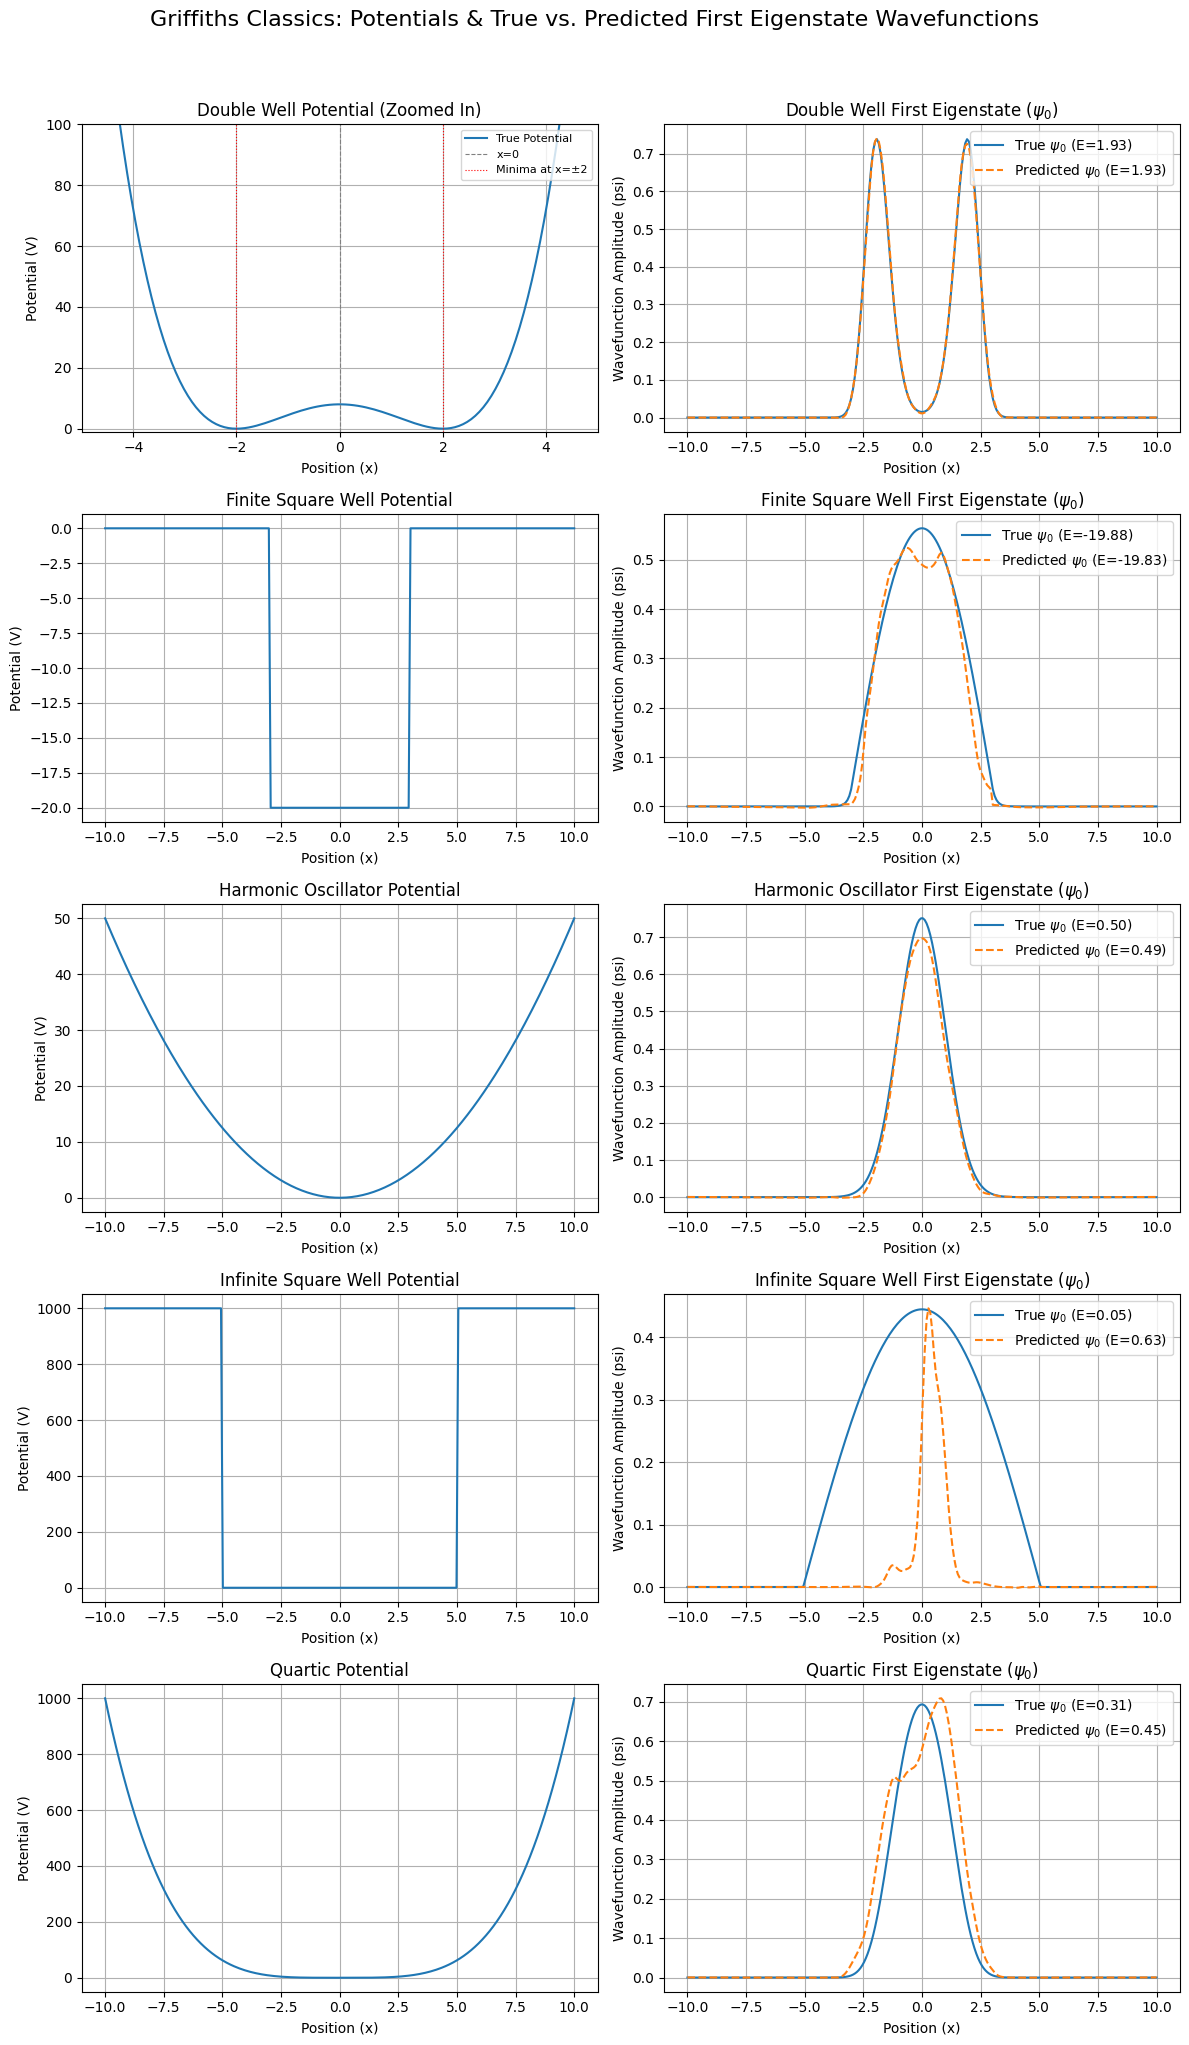

In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch # Added this import

# Re-initialize the generator to get the x_grid
class SchrodingerDataGenerator:
    def __init__(
        self,
        n_points=256,
        x_min=-10.0,
        x_max=10.0,
        n_eigenstates=4,
        hbar=1.0,
        mass=1.0
    ):
        self.n_points = n_points
        self.x = np.linspace(x_min, x_max, n_points)
        self.dx = self.x[1] - self.x[0]
        self.n_eigenstates = n_eigenstates
        self.hbar = hbar
        self.mass = mass

# Create an instance to get the x-grid
generator_for_x = SchrodingerDataGenerator()
x_grid = generator_for_x.x

# Determine device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained model and normalization stats
# Assumes 'fno_enhanced_best.pth' is available and SchrodingerNeuralOperator class is defined in the kernel
checkpoint = torch.load('fno_enhanced_best.pth', map_location=device, weights_only=False)
model_config = checkpoint['config']
normalization_stats = checkpoint['normalization']

# Instantiate model using the config from the checkpoint
model = SchrodingerNeuralOperator(
    n_modes=model_config['n_modes'],
    hidden_channels=model_config['hidden_channels'],
    n_layers=model_config['n_layers'],
    n_eigenstates=model_config['n_eigenstates'],
    n_points=model_config['n_points']
).to(device)

# Get the model's state_dict from the checkpoint
model_state_dict = checkpoint['model_state_dict']

# Remove '_metadata' key if it exists (it's often added by torch.save/load, but not part of model parameters)
if '_metadata' in model_state_dict:
    del model_state_dict['_metadata']

model.load_state_dict(model_state_dict)
model.eval() # Set model to evaluation mode

# Extract normalization stats
V_mean = normalization_stats['V_mean']
V_std = normalization_stats['V_std']
E_mean = normalization_stats['E_mean']
E_std = normalization_stats['E_std']

with h5py.File('schrodinger_training_data.h5', 'r') as f:
    # Access the 'validation' group
    validation_group = f['validation']

    # Get the names of the classic potentials
    classic_names = list(validation_group.keys())
    num_validation_examples = len(classic_names)

    fig, axes = plt.subplots(num_validation_examples, 2, figsize=(12, 4 * num_validation_examples))
    fig.suptitle('Griffiths Classics: Potentials & True vs. Predicted First Eigenstate Wavefunctions', y=1.02, fontsize=16)

    # Get dx from the generator, or from the dataset if available
    # Assuming SchrodingerDataGenerator is consistent with the training data grid
    dx = generator_for_x.dx

    for i, name in enumerate(classic_names):
        # Access potential, energies, and wavefunctions from the specific classic subgroup
        V_classic = validation_group[name]['potential'][:]
        E_classic = validation_group[name]['energies'][:] # True energies
        psi_classic = validation_group[name]['wavefunctions'][:]

        # Prepare input for FNO: Convert to tensor, add batch dimension, and normalize potential
        V_classic_tensor = torch.FloatTensor(V_classic).unsqueeze(0).to(device)
        V_normalized_for_model = (V_classic_tensor - V_mean) / V_std

        # Make prediction with FNO model (now only predicts psi)
        with torch.no_grad():
            psi_pred_tensor = model(V_normalized_for_model)

        # Compute E_pred from psi_pred using physics formula
        E_pred_denormalized = energy_from_psi_multi_eigenstate(
            psi_pred_tensor, V_normalized_for_model, dx, normalization_stats
        )
        # Normalize E_pred for consistency with E_true_normalized in energy_loss (if needed, but not for plotting here)
        # For display, we use denormalized E_pred

        # Move predictions to CPU and convert to numpy
        # E_pred_normalized = E_pred_normalized.squeeze(0).cpu().numpy() # This line is no longer needed
        E_pred_denormalized_np = E_pred_denormalized.squeeze(0).cpu().numpy()
        psi_pred = psi_pred_tensor.squeeze(0).cpu().numpy()


        # Plot Potential (Left Column)
        axes[i, 0].plot(x_grid, V_classic, label='True Potential')
        axes[i, 0].set_title(f'{name.replace("_", " ").title()} Potential')
        axes[i, 0].set_xlabel('Position (x)')
        axes[i, 0].set_ylabel('Potential (V)')
        axes[i, 0].grid(True)

        # Apply zoom for double_well potential for better visualization
        if name == 'double_well':
            axes[i, 0].set_ylim(-1, 100) # Adjust these limits as needed to clearly see the wells and barrier
            axes[i, 0].set_xlim(-5, 5)  # Also limit x-axis for better focus
            axes[i, 0].axvline(x=0, color='gray', linestyle='--', linewidth=0.8, label='x=0')
            axes[i, 0].axvline(x=-2, color='red', linestyle=':', linewidth=0.8, label='Minima at x=\u00b12')
            axes[i, 0].axvline(x=2, color='red', linestyle=':', linewidth=0.8)
            axes[i, 0].legend(loc='upper right', fontsize=8)
            axes[i, 0].set_title(f'{name.replace("_", " ").title()} Potential (Zoomed In)') # Update title for clarity

        # Plot First Eigenstate Wavefunction (Right Column)
        axes[i, 1].plot(x_grid, psi_classic[0], label=f'True $\psi_0$ (E={E_classic[0]:.2f})')
        axes[i, 1].plot(x_grid, psi_pred[0], '--', label=f'Predicted $\psi_0$ (E={E_pred_denormalized_np[0]:.2f})')
        axes[i, 1].set_title(f'{name.replace("_", " ").title()} First Eigenstate ($\psi_0$)')
        axes[i, 1].set_xlabel('Position (x)')
        axes[i, 1].set_ylabel('Wavefunction Amplitude (psi)')
        axes[i, 1].grid(True)
        axes[i, 1].legend()

    plt.tight_layout()
    plt.show()

# Test on finer mesh

This is the unique selling point of Neural Operators. Run on a 1024 point mesh. Interpolate classic potentials to finer mesh and use our trained FNO to predict.


In [11]:
from scipy.interpolate import interp1d
import h5py # Re-import h5py to open the file again

# 2. Define n_points_fine and calculate x_grid_fine
n_points_fine = 1024
x_min_original = generator_for_x.x[0]
x_max_original = generator_for_x.x[-1]
x_grid_fine = np.linspace(x_min_original, x_max_original, n_points_fine)

# 3. Calculate dx_fine
dx_fine = x_grid_fine[1] - x_grid_fine[0]

# 4. Initialize an empty list to store the interpolated data
finer_mesh_data = []

print(f"Original grid: {len(x_grid)} points, dx={dx:.4f}")
print(f"Finer grid: {len(x_grid_fine)} points, dx_fine={dx_fine:.4f}\n")

# Re-open the HDF5 file to access validation_group
with h5py.File('schrodinger_training_data.h5', 'r') as f_reopen:
    validation_group_reopened = f_reopen['validation']

    # 5. Loop through each classic potential name
    for name in classic_names:
        # a. Load the data for the current potential
        V_classic = validation_group_reopened[name]['potential'][:]
        E_classic = validation_group_reopened[name]['energies'][:]
        psi_classic = validation_group_reopened[name]['wavefunctions'][:]

        # b. Create an interpolation function for V_classic
        interp_V = interp1d(x_grid, V_classic, kind='cubic', fill_value='extrapolate')
        # c. Interpolate V_classic to x_grid_fine
        V_fine = interp_V(x_grid_fine)

        # d. Initialize an empty list to store interpolated wavefunctions
        psi_fine_list = []
        # e. For each eigenstate in psi_classic
        for i in range(psi_classic.shape[0]):
            # i. Create an interpolation function for the current eigenstate
            interp_psi = interp1d(x_grid, psi_classic[i], kind='cubic', fill_value='extrapolate')
            # ii. Interpolate the current eigenstate and append
            psi_fine_list.append(interp_psi(x_grid_fine))

        # f. Convert psi_fine_list to a NumPy array
        psi_fine = np.array(psi_fine_list)

        # g. Append the processed data to the finer_mesh_data list
        finer_mesh_data.append({
            'name': name,
            'V_fine': V_fine,
            'E_classic': E_classic,
            'psi_fine': psi_fine
        })

print(f"Interpolation complete for {len(finer_mesh_data)} classic potentials on finer mesh.")

Original grid: 256 points, dx=0.0784
Finer grid: 1024 points, dx_fine=0.0196

Interpolation complete for 5 classic potentials on finer mesh.


## Predict on Finer Mesh




In [12]:
for data_item in finer_mesh_data:
    name = data_item['name']
    V_fine = data_item['V_fine']

    # Convert V_fine to tensor, add batch dimension, and move to device
    V_fine_tensor = torch.FloatTensor(V_fine).unsqueeze(0).to(device)

    # Normalize the V_fine tensor
    V_normalized_fine = (V_fine_tensor - V_mean) / V_std

    # Pass through FNO model to get predicted wavefunctions
    with torch.no_grad():
        psi_pred_tensor_fine = model(V_normalized_fine)

    # Calculate predicted denormalized energies from predicted wavefunctions
    E_pred_denormalized_fine = energy_from_psi_multi_eigenstate(
        psi_pred_tensor_fine,
        V_normalized_fine,
        dx_fine,
        normalization_stats
    )

    # Convert predictions to NumPy and store back into data_item
    data_item['E_pred_fine'] = E_pred_denormalized_fine.squeeze(0).cpu().numpy()
    data_item['psi_pred_fine'] = psi_pred_tensor_fine.squeeze(0).cpu().numpy()

print("Predictions on finer mesh complete and stored in finer_mesh_data.")

Predictions on finer mesh complete and stored in finer_mesh_data.


# Visualize



Saved finer_mesh_predictions.png


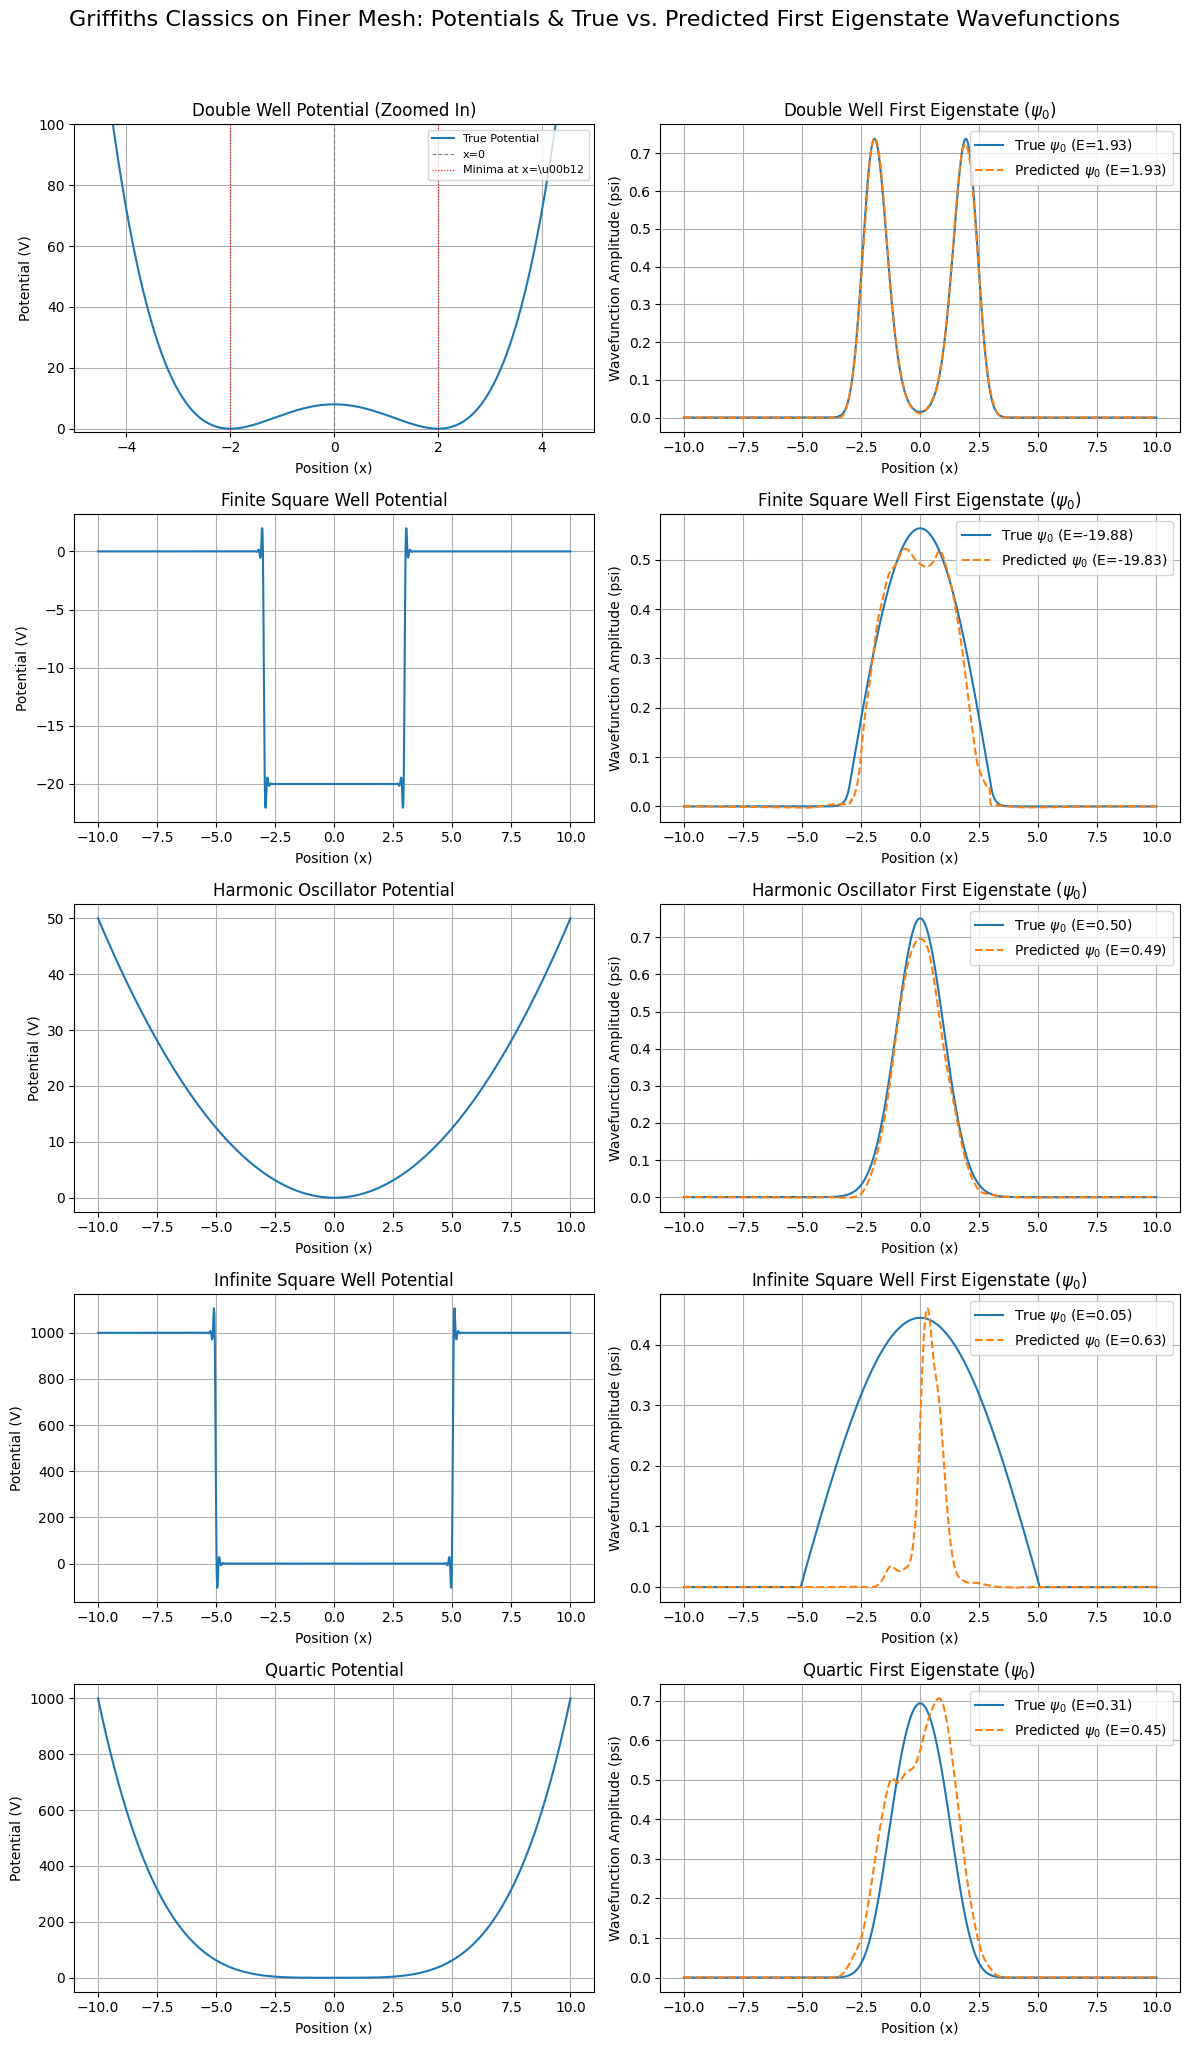

In [15]:
import matplotlib.pyplot as plt

# 1. Initialize a new Matplotlib figure and axes
fig, axes = plt.subplots(len(finer_mesh_data), 2, figsize=(12, 4 * len(finer_mesh_data)))
fig.suptitle('Griffiths Classics on Finer Mesh: Potentials & True vs. Predicted First Eigenstate Wavefunctions', y=1.02, fontsize=16)

# Ensure axes is always a 2D array, even if there's only one potential
if len(finer_mesh_data) == 1:
    axes = np.array([axes])

# 2. Iterate through each data_item in the finer_mesh_data list
for i, data_item in enumerate(finer_mesh_data):
    # 3. Extract relevant data
    name = data_item['name']
    V_fine = data_item['V_fine']
    E_classic = data_item['E_classic']
    psi_fine = data_item['psi_fine']
    E_pred_fine = data_item['E_pred_fine']
    psi_pred_fine = data_item['psi_pred_fine']

    # 4a. Plot V_fine on the left subplot
    axes[i, 0].plot(x_grid_fine, V_fine, label='True Potential')
    axes[i, 0].set_title(f'{name.replace("_", " ").title()} Potential')
    axes[i, 0].set_xlabel('Position (x)')
    axes[i, 0].set_ylabel('Potential (V)')
    axes[i, 0].grid(True)

    # 4b. If 'double_well', adjust y-axis limits and add vertical lines
    if name == 'double_well':
        axes[i, 0].set_ylim(-1, 100) # Adjust these limits as needed
        axes[i, 0].set_xlim(-5, 5)  # Also limit x-axis for better focus
        axes[i, 0].axvline(x=0, color='gray', linestyle='--', linewidth=0.8, label='x=0')
        # Assuming minima are around -2 and 2 based on common double well potentials
        axes[i, 0].axvline(x=-2, color='red', linestyle=':', linewidth=0.8, label=r'Minima at x=\u00b12')
        axes[i, 0].axvline(x=2, color='red', linestyle=':', linewidth=0.8)
        axes[i, 0].legend(loc='upper right', fontsize=8)
        axes[i, 0].set_title(f'{name.replace("_", " ").title()} Potential (Zoomed In)')

    # 4c. Plot the first true eigenstate
    axes[i, 1].plot(x_grid_fine, psi_fine[0], label=rf'True $\psi_0$ (E={E_classic[0]:.2f})')

    # 4d. Plot the first predicted eigenstate
    axes[i, 1].plot(x_grid_fine, psi_pred_fine[0], '--', label=rf'Predicted $\psi_0$ (E={E_pred_fine[0]:.2f})')

    # 4e. Set title, labels, and legend for the right subplot
    axes[i, 1].set_title(f'{name.replace("_", " ").title()} First Eigenstate ${r"\text{(}\psi_0\text{)}"}$ ')
    axes[i, 1].set_xlabel('Position (x)')
    axes[i, 1].set_ylabel('Wavefunction Amplitude (psi)')
    axes[i, 1].grid(True)
    axes[i, 1].legend()

# 5. Adjust the layout of the subplots
plt.tight_layout()

# 6. Save the generated figure
plt.savefig('finer_mesh_predictions.png', dpi=300, bbox_inches='tight')
print("Saved finer_mesh_predictions.png")

# 7. Display and close the plot
plt.show()
plt.close()
